# Vehicle Detection

Note: This file uses car and not car features generated by the script **Project 5 - Train Classifier**. It also uses the classifier model created in the same script.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import cv2
import numpy as np
from pickle import dump
from pickle import load
import configparser as cp
import glob
import time

%matplotlib inline

In [2]:
# Get feature and model File names from saved config file
file_config = cp.ConfigParser()
configs = file_config.read('Project 5 - file_locations.ini')
svc_filename = file_config.get('file_locations', 'svc_filename')
car_features_filename = file_config.get('file_locations', 'car_features_filename')
no_car_features_filename = file_config.get('file_locations', 'no_car_features_filename')

## Functions

### Misc. Functions

In [3]:
def display_images(img, cmap=None):
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 1, 1)    
#     plt.axis('off')
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)

### Feature Extraction Functions

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys', 
                                  transform_sqrt=transform_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2-Hys',
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# def color_hist(img, nbins=32, bins_range=(0, 256)):
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    transform_sqrt=True  # we will set this false if color space = LUV or YUV
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Hog function can cause error in YUV or LUV color spaces
            if color_space == 'LUV' or color_space == 'YUV' :
                transform_sqrt=False
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':                
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, transform_sqrt=transform_sqrt))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True, transform_sqrt=transform_sqrt)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Feature Prediction Functions

In [5]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# Return image
def find_cars_img(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


# Define a single function that can extract features using hog sub-sampling and make predictions
# Return list of boxes
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    car_boxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)            
            if test_prediction == 1:                               
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)               
                car_boxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
    return car_boxes

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        try:
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        except ValueError:  #raised if `y` is empty.
            pass
    # Return the image
    return img

## Test Heat Map

In [7]:
# Parameters for model
svc = load(open(svc_filename, 'rb'))
car_features = load(open(car_features_filename, 'rb'))
notcar_features = load(open(no_car_features_filename, 'rb'))

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [8]:
# Parameters for feature extraction
pix_per_cell = 16
cell_per_block = 2 # HOG cells per block
orient = 9
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 650] # Min and max in y to search in slide_window()
scale = 1.2
xstart = 300
xstop = 1280


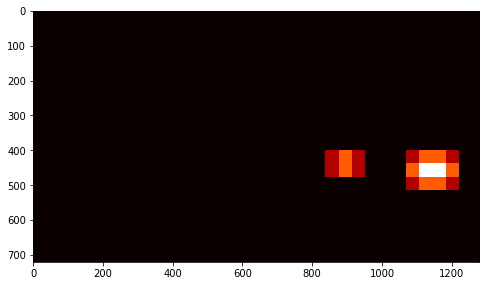

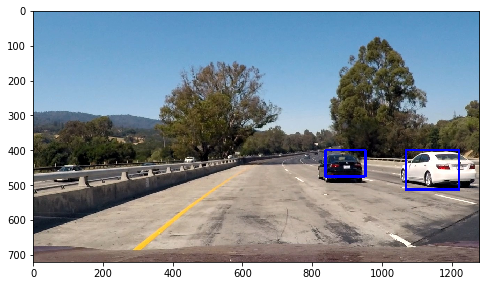

In [9]:
img = 'test_images/test1.jpg'
image = mpimg.imread(img)
out_img = find_cars(image, y_start_stop[0], y_start_stop[1], xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,out_img)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0.5)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
display_images(heatmap, cmap='hot')
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

display_images(draw_img)

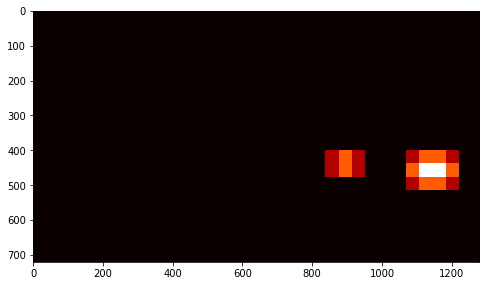

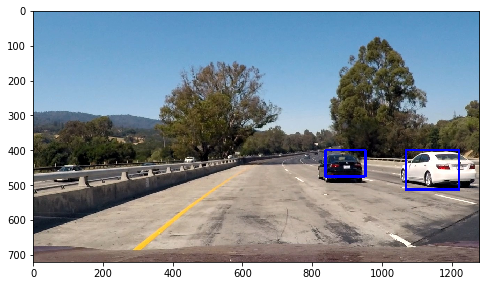

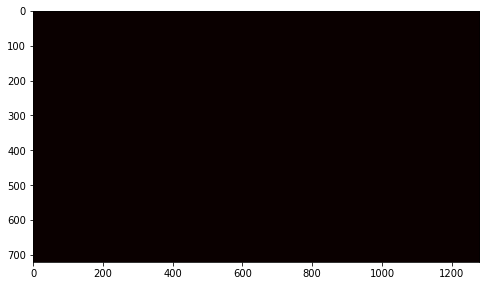

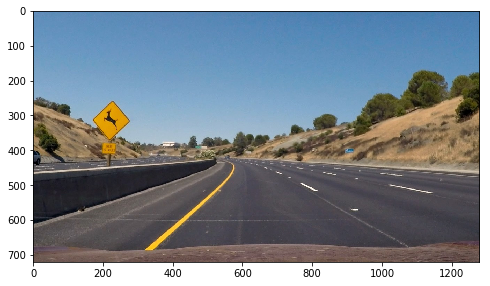

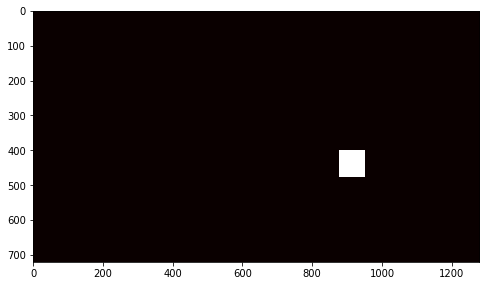

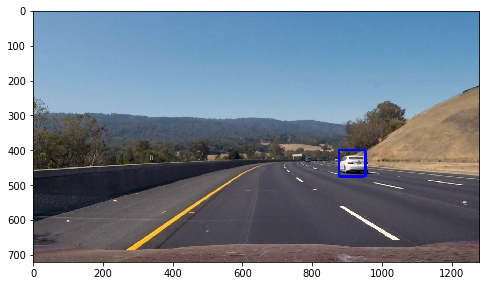

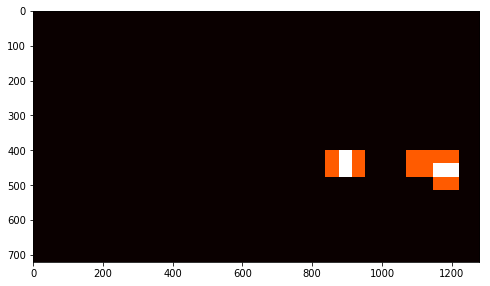

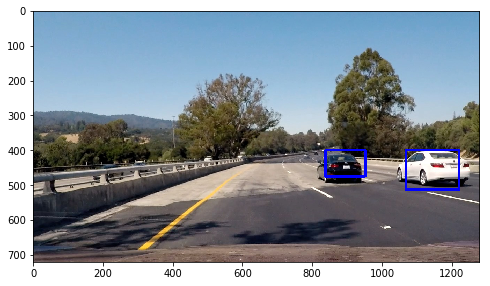

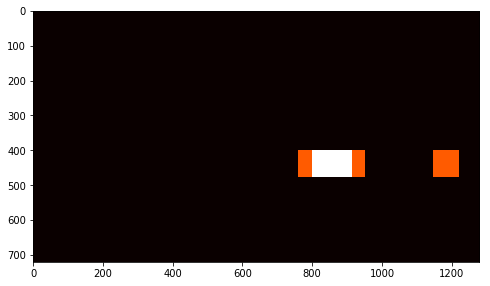

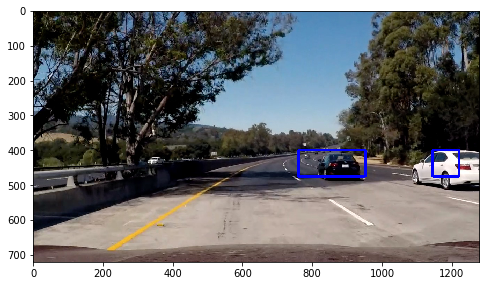

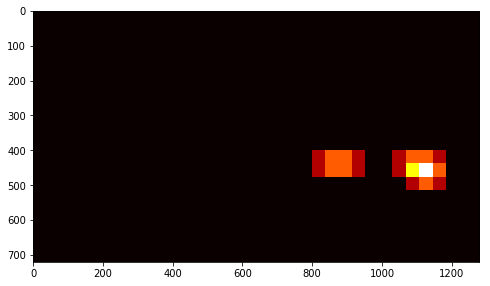

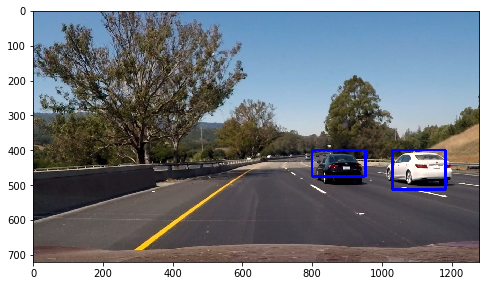

In [10]:
test_images = glob.glob('test_images/*.jpg')

y_start_stop = [400, 650] # Min and max in y to search in slide_window()
xstart = 300
xstop = 1280
scale = 1.2


for img in test_images:
    image = mpimg.imread(img)        
    out_img = find_cars(image, y_start_stop[0], y_start_stop[1], xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
               
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,out_img)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0.5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    display_images(heatmap, cmap='hot')
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    display_images(draw_img)

# Smoothing

In order to remove most false positives, we will average out the detections over n frames

In [11]:
# Class to store recent detected Heatmaps
class HeatMaps():
    def __init__(self):        
        self.recent_heatmaps = [] 
            
    def add_heatmap(self, label):
        self.recent_heatmaps.append(label)
        smoothing_factor = 5
        if len(self.recent_heatmaps) > smoothing_factor:
            self.recent_heatmaps.pop(0)
        return self.recent_heatmaps

# Smooth out heatmaps over the past n frames
def smooth_heatmaps(heatmaps):
    flattened = []
    for a in heatmaps:
        flattened.append(a.ravel())
    flattened = np.asarray(flattened)
    average_heatmaps = np.median(flattened, axis=0).astype(int)
    average_heatmaps = average_heatmaps.reshape(-1, len(heatmaps[0][1]))
    return average_heatmaps

In [12]:
zone1 ={'start':400, 'stop':500, 'xstart':480, 'xstop':1280, 'scale':1} 
zone2 ={'start':400, 'stop':550, 'xstart':550, 'xstop':1280, 'scale':1.5}  
# zone3 ={'start':500, 'stop':660, 'xstart':550, 'xstop':1280, 'scale':2.0}  
# zone4 ={'start':400, 'stop':660, 'scale':2.5}  


detected_heatmaps = HeatMaps()  # To store previous and current heatmaps


# Image process pipeline
def image_process(image):
    box_list = []  # store detected boxes
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    out_img = find_cars(image, zone1['start'], zone1['stop'], zone1['xstart'], zone1['xstop'], zone1['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list.append(out_img)
    
    out_img = find_cars(image, zone2['start'], zone2['stop'], zone2['xstart'], zone2['xstop'], zone2['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list.append(out_img)
       
#     out_img = find_cars(image, zone3['start'], zone3['stop'], zone3['xstart'], zone3['xstop'],zone3['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     box_list.append(out_img)
    
#     out_img = find_cars(image, zone4['start'], zone4['stop'], zone4['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     box_list.append(out_img)
    
    boxes = [box for sub_box_list in box_list for box in sub_box_list]    
 
    
    heatmap_img = np.zeros_like(image[:,:,0])  
    heatmap_img = add_heat(heatmap_img, boxes)  # Add heat to each box in box list       
    heatmap_img = detected_heatmaps.add_heatmap(heatmap_img)  # store previous n heatmaps
    heatmap_img = smooth_heatmaps(heatmap_img)  # smooth out previous n heatmaps
    heatmap_img = apply_threshold(heatmap_img, 0.95)  # Apply threshold to help remove false positives      
    
    labels = label(heatmap_img)  # Find final boxes from heatmap using label function    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)  
    return draw_img

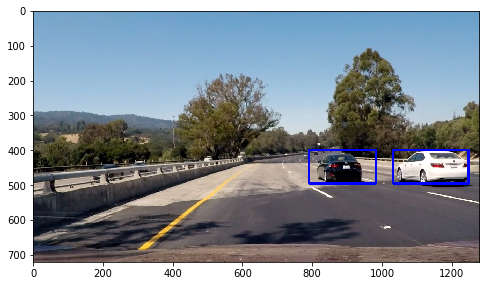

In [13]:
img = 'test_images/test4.jpg'
image = mpimg.imread(img)
out = image_process(image)
display_images(out)

# Process Video

In [14]:
# Process input video
vid_in = 'project_video.mp4'
# vid_in = 'project_videoTrim4.mp4'
vid_out = 'Project 5 Output.mp4'
clip_in = VideoFileClip(vid_in)
clip_out = clip_in.fl_image(image_process) 
clip_out.write_videofile(vid_out, audio=False)

[MoviePy] >>>> Building video Project 5 Output.mp4
[MoviePy] Writing video Project 5 Output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:34<00:00,  7.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project 5 Output.mp4 

